# Word prediction in historical linguistics
This is a Jupyter notebook and Python library to demonstrate the use of word prediction using deep learning as an aid in historical linguistics. This notebook accompanies the following paper: Dekker, P. & Zuidema, W. (2021). Word Prediction in Computational Historical Linguistics. _Journal of Language Modelling_ (forthcoming). The results yielded by this demonstrational notebook may differ somewhat from the results in the article.

Any questions or problems?
 * [Contact me](https://peterdekker.eu/#contact)
 * [File a bug report](https://github.com/peterdekker/prediction-histling/issues)

## Prerequisites

### Application and data loading
**Run this cell before running other cells.** Execution of this cell takes a long time the first time, since automatic cognate judgments (using external LexStat algorithm) are inferred for the whole data set. These cognate judgments are used to perform evaluation of the word prediction algorithm. To enable GPU support for the encoder-decoder, refer to the [Theano documentation](http://deeplearning.net/software/theano/tutorial/using_gpu.html).

The following settings can be changed by the user. **The kernel should be restarted (Kernel > Restart) after changing options.**
 * Set languages by alternatively setting one of these two variables:
   * `languages`: Give a list of languages (language codes from [NorthEuraLex](http://northeuralex.org/languages)) to take under consideration.
   * `lang_family`: `None`, `slav` or `ger`. If `lang_family` has been set (not `None`), `languages` will be disregarded. If `lang_family` is `None`, `languages` will be used.
 * `cognate_detection`: `False` by default, which allows multiple forms per concept, which leads to a larger data set. If you would like to be able to perform cognate detection based on prediction results (a later step in this notebook), set this variable to `True`, which restricts the data set to one form per concept.

 * `input_encoding`: the procedure used to encode phonemes into input vectors. `embedding` by default. Can be set to `character` (one-hot), `phonetic` or `embedding`.
 * `export_weights`: `False` by default. Set to `True` to be able to export and visualize the weights of the encoder-decoder. Do this only for diagnostic/visualization purposes, because the batch size will be set to 1, which does not give optimal performance.
 * `view_embedding_ipa`: `True` by default. Internally, the ASJP character set is used to predict words. To view the embedding encoding visualization as IPA, set this to True. If False, embedding encoding visualization will be shown in ASJP. Note: this option is purely aesthetical.


Other, more advanced, options can be set in the file `util/config.py`.

In [2]:
from util import init
from dataset import data
from util.config import config
import pandas as pd
import sys

lang_family_dict = {
"slav": ["ces", "bul", "rus", "bel", "ukr", "pol", "slk", "slv", "hrv"],
"ger": ["swe", "isl", "eng", "nld", "deu", "dan", "nor"]
}

#--------------------------------------------------------------------
# VARIABLES TO BE SET BY USER
languages = ["nld","deu","eng"]
lang_family = None
cognate_detection = False
config["export_weights"] = False
config["input_encoding"] = "embedding"
config["view_embedding_ipa"] = True
#--------------------------------------------------------------------

i_enc = config["input_encoding"]
o_enc = config["output_encoding"]

if config["export_weights"]:
    config["batch_size"]=1

if lang_family:
    languages = lang_family_dict[lang_family]

options, distances_path, baselines_path = init.initialize_program(cognate_detection, config=config)
(results_path, output_path_cognates_train, output_path_cognates_valtest,
context_vectors_path, subs_sp_path, subs_st_path, lang_pairs, train, val, test, max_len, 
conversion_key, voc_size, feature_matrix_phon) = data.load_data(train_corpus="northeuralex",
                                                               valtest_corpus="northeuralex",
                                                               languages=languages,  
                                                               input_type="asjp", 
                                                               options=options,
                                                               cognate_detection=False,
                                                               config=config)

Initializing program...


2021-01-11 12:58:05,058 [INFO] Successfully changed parameters.


Unpacking archive and deleting archive file.
Loading phonetic feature matrix...
Generating all language pairs...
Training corpus:
 - Loading dataset and performing necessary conversion/tokenization.
Using existing wordlist file, nothing is generated.
 - Detect cognates in entire dataset using LexStat.
Using existing cognates file output/northeuralex-asjp-cognates.tsv, nothing is generated.
Train corpus is valtest corpus.
Creating feature matrix for this specific language pair...
 - Creating embedding for nld
 -- Using existing embedding file for nld
Converting training corpus TSV file to data matrix...
Converting val/test corpus TSV file to data matrix...
USE TRAIN M/S
Dividing into training, validation and test set...
Train/val/test sizes: 723|0|0
Train/val/test sizes: 0|230|230
Filtering val/test sets on cognates...
Val/test sizes after cognate filtering: 157|135
Creating feature matrix for this specific language pair...
 - Creating embedding for nld
 -- Using existing embedding file

### Visualize encoding
Visualize the representation of phonemes in the embedding encoding, as PCA and as hierarchically clustered tree. Compare them to the phonetic feature matrix from Brown (2008).

In [3]:
from dataset import data
from visualize import visualize
from tree import cluster
from util.asjp2ipa import asjp_to_ipa

tree_style = config["ete_tree_style"]

print("Phonetic matrix from Brown (2008):")
# Perform PCA on phonetic feature matrix from Brown (2008)
phon_matrix_red, phon_phonemes = visualize.dim_reduction(feature_matrix_phon)
# If enabled, convert ASJP phonemes to IPA for plot
if config["view_embedding_ipa"]:
    phon_phonemes = [asjp_to_ipa(p) for p in phon_phonemes]
# Visualize phonetic feature PCA using plot
visualize.visualize_encoding(phon_matrix_red, phon_phonemes, "phonetic-pca", config)
# Hierarchically cluster distances between phonemes in phonetic feature matrix
tree = cluster.cluster_phonemes_encoding(feature_matrix_phon, phon_phonemes, "phonetic", config)

display(tree.render("%%inline", tree_style=tree_style))

for lang_pair in lang_pairs:
    lang_a = lang_pair[0]
    print(f"Embedding for {lang_a}:")
    # Create embedding for every first language in language pair
    emb_matrix = data.create_embedding(lang_a, [output_path_cognates_train, output_path_cognates_valtest], config)
    # Perform PCA on embedding matrix
    emb_matrix_red, emb_phonemes = visualize.dim_reduction(emb_matrix)
    # If enabled, convert ASJP phonemes to IPA for plot
    if config["view_embedding_ipa"]:
        emb_phonemes = [asjp_to_ipa(p) for p in emb_phonemes]
    # Visualize embedding PCA using plot
    visualize.visualize_encoding(emb_matrix_red, emb_phonemes, f"embedding-{lang_pair[0]}-pca", config)
    
    # Hierarchically cluster distances between phonemes in embedding matrix
    tree = cluster.cluster_phonemes_encoding(emb_matrix, emb_phonemes, f"embedding-{lang_pair[0]}", config)
    display(tree.render("%%inline", tree_style=tree_style))
    

TypeError: __init__() got an unexpected keyword argument 'laterality'

#### Close-up: constrast occurrences of phonemes in data
Interesting patterns in the phoneme encoding visualizations, can be looked up in the data. In the Dutch embedding encoding, we saw that *t* and *d*, closely related phonemes, are quite remote in the embedding space. How do the words with *t* and *d*, on which the embedding encoding is based, look in Dutch?

In [4]:

lang = "nld"
# Read in TSV file with data
df = pd.read_csv(output_path_cognates_train, sep="\t", engine="python", skipfooter=3, index_col=False)
df_lang = df[df["DOCULECT"] == lang]

for phoneme in ["d", "t"]:
    print(phoneme)
    words_with_phoneme = df_lang[df_lang["ASJP"].str.contains(phoneme)]
    total = len(words_with_phoneme)
    print(f"Total number of occurrences: {total}")
    
    # Compute locations of phonemes in word
    locations = df_lang["ASJP"].str.find(phoneme)
    locations = locations[locations != -1]
    # Compute relative frequencies
    locations_relfreq = locations.value_counts(normalize=True)
    print("Relative frequencies of locations:")
    print(locations_relfreq)
    # Look up words with most frequent location
    most_freq_location = int(locations.mode())
    words_in_most_freq_loc = words_with_phoneme[words_with_phoneme["ASJP"].str.find(phoneme) == most_freq_location]
    print(f"Words with {phoneme} where {phoneme} has most frequent location in word ({most_freq_location}):")
    print(words_in_most_freq_loc)
    print("")
    


d
Total number of occurrences: 206
Relative frequencies of locations:
0     0.300971
3     0.257282
2     0.169903
4     0.087379
5     0.058252
6     0.053398
7     0.038835
1     0.014563
8     0.014563
10    0.004854
Name: ASJP, dtype: float64
Words with d where d has most frequent location in word (0):
           ID DOCULECT GLOTTOCODE      CONCEPT WORD_FORM      RAWIPA  \
2089    59962      nld   dutc1256      Arzt::N    dokter      dɔktər   
7242    59849      nld   dutc1256      Dach::N       dak         dɑk   
7360    59923      nld   dutc1256     Decke::N     deken      ˈdeːkə   
7485    59871      nld   dutc1256    Deckel::N    deksel      dɛksəl   
7603    60020      nld   dutc1256  Dezember::N  december  deˑˈsɛmbər   
...       ...      ...        ...          ...       ...         ...   
108633  60339      nld   dutc1256   trinken::V   drinken      drɪnkə   
108746  60058      nld   dutc1256   trocken::A     droog       droːx   
108862  60299      nld   dutc1256  trocknen:

[135 rows x 19 columns]






### Show number of cognates in training data
Show the number of cognate word pairs per language pair in the training data, and calculate cliques of languages with a minimum of 100 shared cognates. These cliques can later be used, to have a group of languages with a large shared number of cognates, to perform prediction on.

In [5]:
cog_per_lang, cliques = data.compute_n_cognates(lang_pairs, output_path_cognates_train, langs=languages, cognates_threshold=100, config=config)
print("Cognates per language: ")
print(cog_per_lang)
print("Cliques: ")
for c in cliques:
    print(c)

Calculate number of cognates per language...


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Calculate cliques...
Cognates per language: 
            Cognates
(nld, deu)       726
(deu, nld)       726
(nld, eng)       353
(eng, nld)       353
(deu, eng)       302
(eng, deu)       302
Cliques: 
['nld', 'deu', 'eng']


## Word prediction
Choose a model to run to perform word prediction: structured perceptron or RNN encoder-decoder. Structured perceptron has the shortest run time. The results of the model run latest for a language pair are saved, and can be used for subsequent applications in the notebook (e.g. phylogenetic tree reconstruction).

### Word prediction using structured perceptron

In [ ]:
from prediction import prediction

for lang_pair in lang_pairs:
    lang_a, lang_b = lang_pair
    print("Performing structured perceptron word prediction for pair (" + lang_a + ", " + lang_b + ")")
    prediction.word_prediction_seq(lang_a, lang_b, train[lang_pair], val[lang_pair], test[lang_pair], conversion_key[lang_pair], results_path[lang_pair], distances_path + ".txt", config)
        

### Word prediction using encoder-decoder
To enable GPU support, refer to the [Theano documentation](http://deeplearning.net/software/theano/tutorial/using_gpu.html), and restart the first cell.

In [ ]:
from prediction import prediction

for lang_pair in lang_pairs:
    lang_a,lang_b = lang_pair
    print("Performing RNN word prediction for pair (" + lang_a + ", " + lang_b + ")")
    prediction.word_prediction_rnn(lang_a, lang_b, (max_len[lang_a], max_len[lang_b]), train[lang_pair], val[lang_pair], test[lang_pair], conversion_key[lang_pair], (voc_size[i_enc][lang_a],voc_size[o_enc][lang_b]), results_path[lang_pair], distances_path + ".txt", context_vectors_path[lang_pair] + ".p", config["output_encoding"], config)


### Baseline for prediction

In [ ]:
from models import baseline
from dataset import Subset

import numpy as np

for lang_pair in lang_pairs:
    lang_a,lang_b = lang_pair
    conv = conversion_key[lang_pair]
    sounds = (list(conv[0].values()), list(conv[1].values()))
    training_frame = train[lang_pair].get_dataframe(conv, i_enc, o_enc)
    testing_frame = test[lang_pair].get_dataframe(conv, i_enc, o_enc)
    baseline.compute_baseline(lang_a, lang_b, sounds, training_frame, testing_frame, baselines_path + ".txt")

### Applications

#### Identify sound correspondences
##### Based on output substitutions
This shows the substitutions table in the notebook, and outputs it as LaTeX table to `RESULTS_DIR/subs-LANG1-LANG2.tex`.

In [ ]:
from visualize import visualize


for lang_pair in lang_pairs:
    lang_a, lang_b = lang_pair
    visualize.show_output_substitutions(results_path[lang_pair], subs_st_path[lang_pair], subs_sp_path[lang_pair], lang_a, lang_b, config)

##### Based on context vector weights (only when weight exported activated)
This works when word prediction with encoder-decoder has been run, and weight export has been activated at the top of this notebook. Executing this command shows the distances between input, output and context vectors. Furthermore, it generates PCA plots of the input, output and context vectors and generates LaTeX files.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from visualize import visualize

for lang_pair in lang_pairs:
    visualize.visualize_weights(context_vectors_path[lang_pair], lang_pair, i_enc, o_enc, config["results_dir"], sample=None)


#### Phylogenetic tree reconstruction

##### Clustering based on word prediction

In [ ]:
from tree import cluster

# Cluster based on word prediction distances
trees = cluster.cluster_languages(lang_pairs, distances_path, output_path=distances_path, config=config)

# Show trees in notebook
for tree in trees:
    print(tree)
    display(tree.render("%%inline",tree_style=config["ete_tree_style"]))

##### Clustering based on baseline

In [ ]:
from tree import cluster

# Source prediction baseline
print("Source word baseline tree")
strees = cluster.cluster_languages(lang_pairs, baselines_path, output_path=baselines_path + "_source", config=config, distance_col=2)
for stree in strees:
    print(stree)
    display(stree.render("%%inline",tree_style=config["ete_tree_style"]))

# PMI-based baseline
print("PMI-based baseline tree")
ptrees = cluster.cluster_languages(lang_pairs, baselines_path, output_path=baselines_path + "_pmi", config=config, distance_col=3)
for ptree in ptrees:
    print(ptree)
    display(ptree.render("%%inline",tree_style=config["ete_tree_style"]))

##### Draw tree from existing newick string (no distance calculcation)
This code can be used to draw trees as image, for which the newick string representation of the tree has already been generated by an earlier run of the clustering algorithm. A collection of previously generated tree strings can be found in the folder `data/trees`.

output/tree_slav_glottolog.pdf


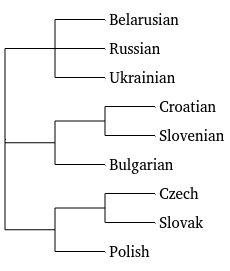

output/tree_slav_structperc_emb_nj.pdf


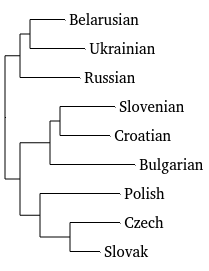

output/tree_slav_structperc_emb_upgma.pdf


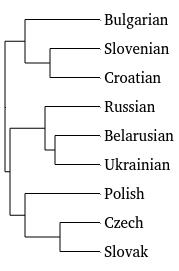

In [6]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace
from scipy.spatial.distance import pdist, squareform

# A number of sample newick strings, you can add your own here.
slav_glottolog = "((bel,rus,ukr),((hrv,slv),bul),((ces,slk),pol));"
slav_structperc_emb_nj = "(((bel:0.07,ukr:0.11):0.02,rus:0.12):0.03,(((slv:0.11,hrv:0.1):0.02,bul:0.17):0.06,(pol:0.16,(ces:0.1,slk:0.06):0.06):0.04):0.03);"
slav_structperc_emb_upgma = "((bul:0.15,(slv:0.1,hrv:0.1):0.05):0.04,((rus:0.11,(bel:0.09,ukr:0.09):0.02):0.07,(pol:0.15,(ces:0.08,slk:0.08):0.07):0.03):0.01);"

# If turned on, replace language code by language names from lang_dict
USE_LANGUAGE_NAMES = True
lang_dict = {"rus": "Russian", "bel":"Belarusian", "ukr":"Ukrainian", "hrv":"Croatian", "slv":"Slovenian", "bul":"Bulgarian", "ces":"Czech", "slk":"Slovak", "pol":"Polish"}


for name,newick_string in [("slav_glottolog", slav_glottolog),
                           ("slav_structperc_emb_nj",slav_structperc_emb_nj),
                           ("slav_structperc_emb_upgma",slav_structperc_emb_upgma)]:
    if USE_LANGUAGE_NAMES:
        for code in lang_dict:
            newick_string = newick_string.replace(code, lang_dict[code])
    if name=="slav_glottolog": # glottolog tree is without length
        ts = TreeStyle()
        ts.show_scale = False
        ts.show_leaf_name = False
        ts.force_topology = False
        ts.show_border = False
        ts.margin_top = ts.margin_bottom = ts.margin_right = ts.margin_left = 5
        ts.scale = 50
        ts.branch_vertical_margin= 10
    else:
        ts = TreeStyle()
        ts.show_scale = False
        ts.show_leaf_name = False
        ts.force_topology = False
        ts.show_border = False
        ts.margin_top = ts.margin_bottom = ts.margin_right = ts.margin_left = 5
        ts.scale = 500
        ts.branch_vertical_margin= 10
    # Load newick string into ete3 Tree object
    tree = Tree(newick_string)
    for node in tree.traverse():
        node.set_style(config["ete_node_style"])
        if node.is_leaf():
            # Add bit of extra space between leaf branch and leaf label
            name_face = TextFace(f" {node.name}", fgcolor="black", ftype="Charis SIL Compact", fsize=11)
            node.add_face(name_face, column=0, position='branch-right')
    print(f"output/tree_{name}.pdf")
    tree.render(f"output/tree_{name}.pdf", tree_style=ts)
    display(tree.render(f"%%inline", tree_style=ts))

#### Cognate detection
To perform this step, the word prediction step has to be performed, with `cognate_detection=True` in the first initialization cell.

In [7]:
from cognatedetection import cd


print("Performing WP cognate detection using clustering...")
results_table = cd.cognate_detection_cluster(lang_pairs, config["results_dir"], options, use_distance="prediction")
print(results_table)

Performing WP cognate detection using clustering...


FileNotFoundError: [Errno 2] No such file or directory: 'output/deu-nld.bat_siz10.bid_enc.v1.4..v1.4..cog_pri1.0.dro0.1.asjp_phone_featu_new.t.fil_tra1.0.gru.gra_cli100.xavie_norma.embed.asjp.lea_rat0.01.lr_dec1.0.n_epo15.n_hid400.n_ite_seq100.n_lay_dec1.n_lay_den1.n_lay_enc1.adagr.chara.outpu.vie_emb_ipa..tsv'